## 1. Imports and Data Loading

In [1]:
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset, DatasetDict , load_from_disk
import pandas as pd
from transformers import AutoTokenizer, AutoModel, TrainingArguments, Trainer, DataCollatorWithPadding 
import torch
from torch import nn
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pd.set_option('display.max_colwidth', None) 

/home/d3v/anaconda3/envs/wysa/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device

device(type='cuda')

In [3]:
file_path = "data.xlsx" 
train_df = pd.read_excel(file_path, sheet_name="Train")
test_df = pd.read_excel(file_path, sheet_name="Test")
train_df.shape, test_df.shape

((8589, 3), (504, 1))

In [4]:
# Remove the single row 
train_df = train_df.dropna(subset=['tweet_text'])

In [5]:
# Separating data that have empty emotion_in_tweet_is_directed_at.

missing_emotion_df = train_df[train_df['emotion_in_tweet_is_directed_at'].isna()]
missing_emotion_df.shape

(5297, 3)

In [6]:
missing_emotion_df.is_there_an_emotion_directed_at_a_brand_or_product.value_counts()

is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    5297
Name: count, dtype: int64

- **We find out samples that have NaN in emotion_in_tweet_is_directed_at are "No emotion toward brand or product" or you can assume neutral emotion**

## 2.EDA

### Category % Check 

In [7]:
train_df.emotion_in_tweet_is_directed_at.value_counts()

product_percentages = train_df['emotion_in_tweet_is_directed_at'].value_counts(normalize=True) * 100
print(product_percentages.round(2))

emotion_in_tweet_is_directed_at
iPad                               28.75
Apple                              20.09
iPad or iPhone App                 14.28
Google                             13.07
iPhone                              9.02
Other Google product or service     8.90
Android App                         2.46
Android                             2.37
Other Apple product or service      1.06
Name: proportion, dtype: float64


### Emotion % Check 

In [8]:
train_df.is_there_an_emotion_directed_at_a_brand_or_product.value_counts()

is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    5388
Positive emotion                      2672
Negative emotion                       519
I can't tell                             9
Name: count, dtype: int64

- **Here we only keep the Major class of Emotions, we can remove "I can't tell" as it has very negilible sample count.**
  

In [9]:
train_df = train_df[train_df['is_there_an_emotion_directed_at_a_brand_or_product'] != "I can't tell"]
train_df.is_there_an_emotion_directed_at_a_brand_or_product.value_counts()

emotion_percentages = train_df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts(normalize=True) * 100
print(emotion_percentages.round(2))

is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    62.80
Positive emotion                      31.15
Negative emotion                       6.05
Name: proportion, dtype: float64


/tmp/ipykernel_4894/4276409513.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=product_percentages.index, y=product_percentages.values, palette='magma')


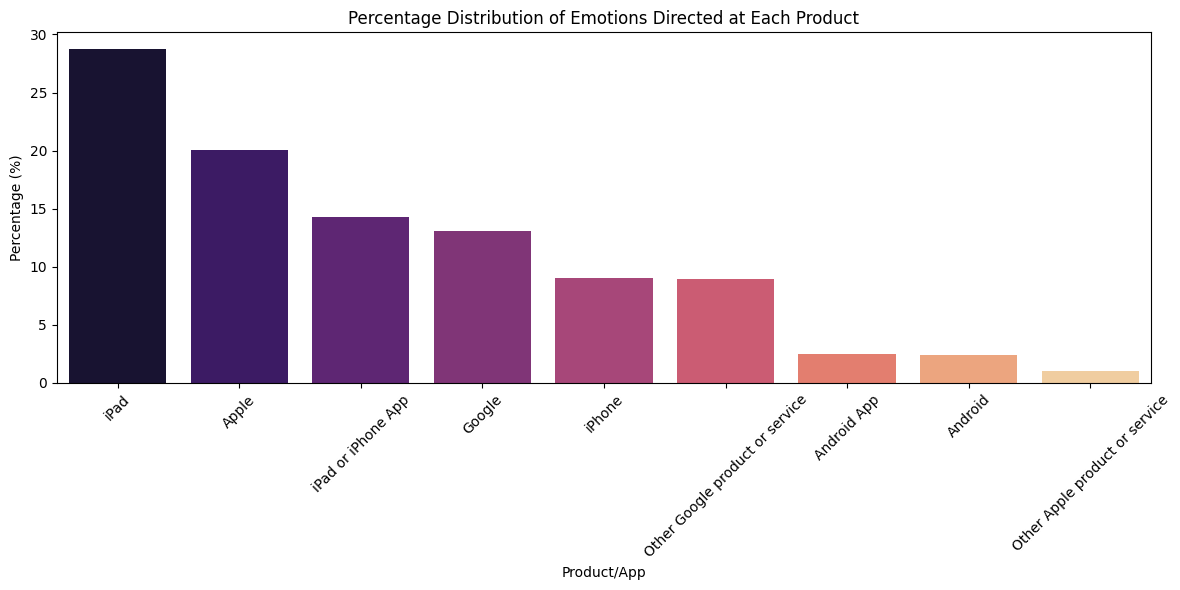

In [10]:
plt.figure(figsize=(12, 6))
sns.barplot(x=product_percentages.index, y=product_percentages.values, palette='magma')
plt.title('Percentage Distribution of Emotions Directed at Each Product')
plt.xlabel('Product/App')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

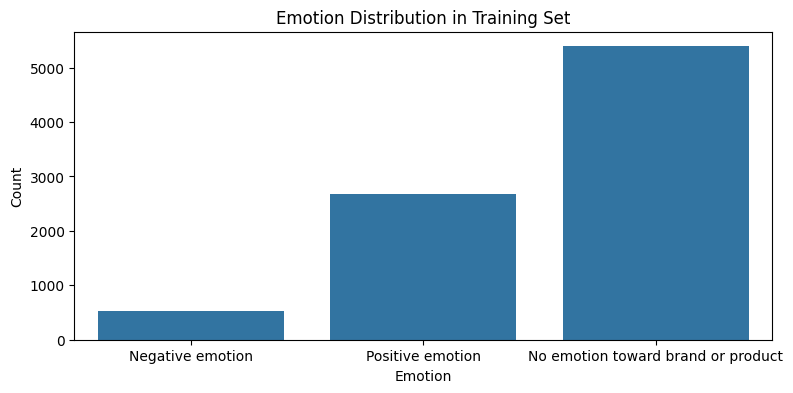

<Figure size 2000x1200 with 0 Axes>

In [11]:
plt.figure(figsize=(9,4))
sns.countplot(data=train_df, x='is_there_an_emotion_directed_at_a_brand_or_product')
plt.title('Emotion Distribution in Training Set')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.figure(figsize=(20,12))
plt.show()

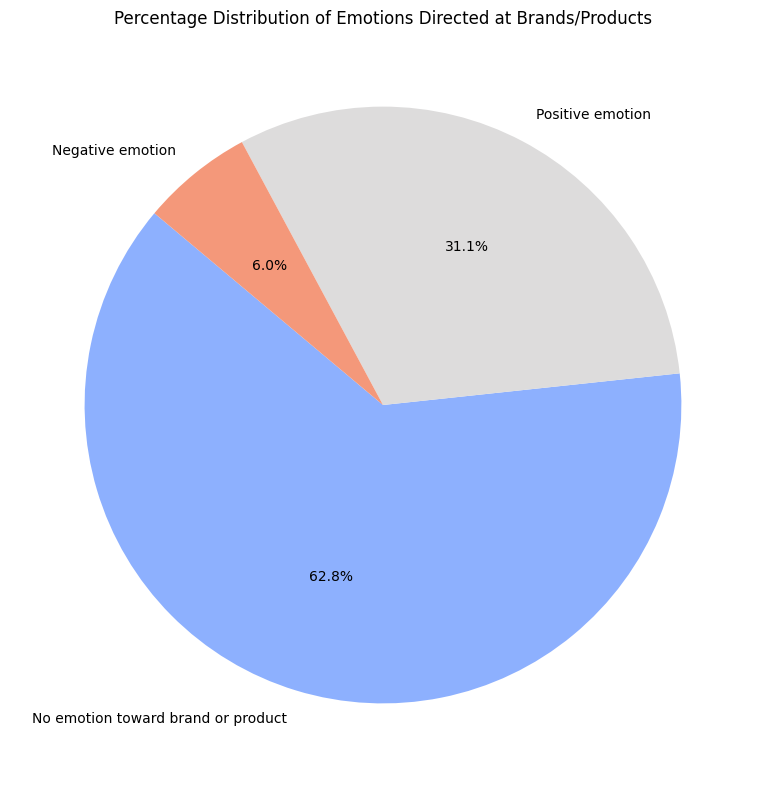

In [12]:
plt.figure(figsize=(8, 8))
emotion_percentages.plot.pie(autopct='%1.1f%%', startangle=140, colors=sns.color_palette('coolwarm', len(emotion_percentages)))
plt.title('Percentage Distribution of Emotions Directed at Brands/Products')
plt.ylabel('')  # Hide y-label
plt.tight_layout()
plt.show()

### Analyzing the Relationship Between Emotion and Product

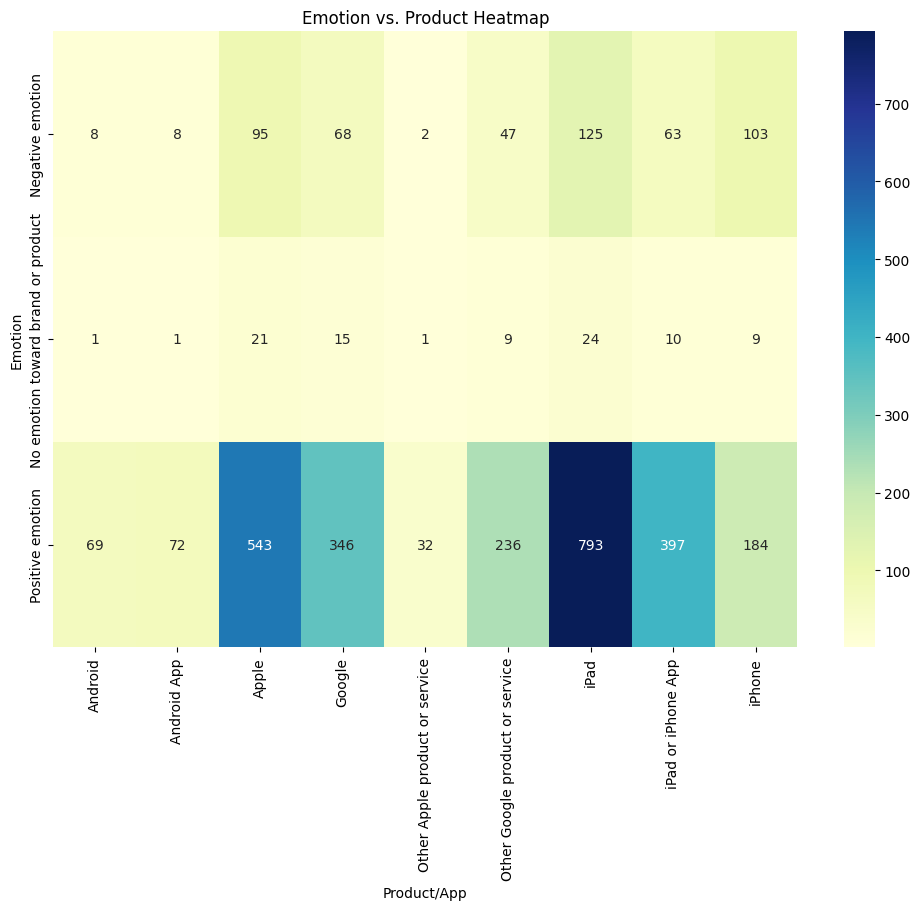

In [13]:
# Crosstab between emotion and product
emotion_product_ct = pd.crosstab(train_df['is_there_an_emotion_directed_at_a_brand_or_product'],
                                 train_df['emotion_in_tweet_is_directed_at'])
# print(emotion_product_ct)

# Heatmap of the crosstab
plt.figure(figsize=(12,8))
sns.heatmap(emotion_product_ct, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Emotion vs. Product Heatmap')
plt.xlabel('Product/App')
plt.ylabel('Emotion')
plt.show()


**Observations & Patterns**
Hypothetical Findings:

1. **Dominance of Neutral/No Emotion:**

- The category "No emotion toward brand or product" is dominant across several products, with relatively high values. This suggests that many users either do not express a strong emotional response (positive or negative) towards these products or that the majority of reviews or comments may be neutral. This need to Downsample for making a better dataset.

2. **Product-Specific Emotional Trends:**

- Apple Products (e.g., iPad, iPhone): There is a notably high positive emotional response towards iPad, with a count of 793. This could indicate that users have a particularly favorable view of the iPad. Other Apple products like "Apple" and "iPhone" also show positive responses, but the iPad stands out significantly.
- Google Products: There are moderate counts of positive and neutral responses towards Google and Other Google products or services, suggesting a mix of responses. The positive emotion count is higher than the negative emotion for Google products, but they don't reach the same positive peak as Apple's iPad.
Product Distribution: there are 10 class, inbetween them 3 classes are have very less sample - 

- Out of 10 classes , there are 3 class where its sum of distribution is only 6%. 
> Android App -- 2.46
> 
> Android -- 2.37
> 
> Other Apple product or service -- 1.06

Emotion-Product Relationship: Certain emotions are more prevalent with specific products (e.g., 'frustrated' with electronics due to technical issues).
Text Length: Variations in the length of textual feedback across different emotions.

3. **Negative Emotions:**

- Negative emotional responses are generally low across all products. However, products such as Android and Android App have small but notable counts of negative emotions, which could suggest some dissatisfaction among users for these specific categories.


### Word Cloud for Each Emotion

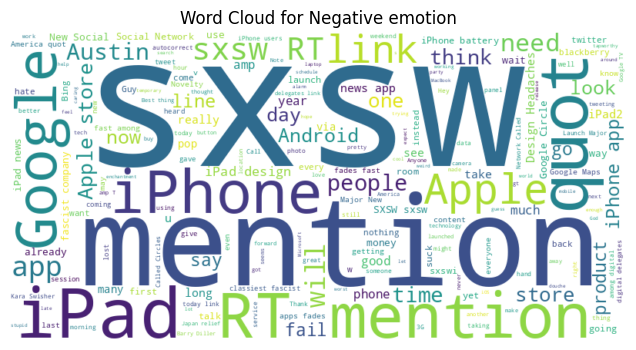

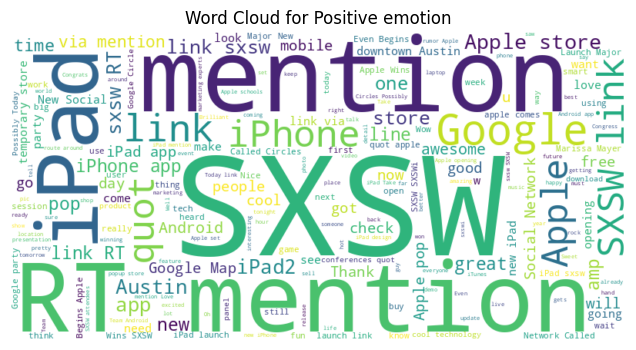

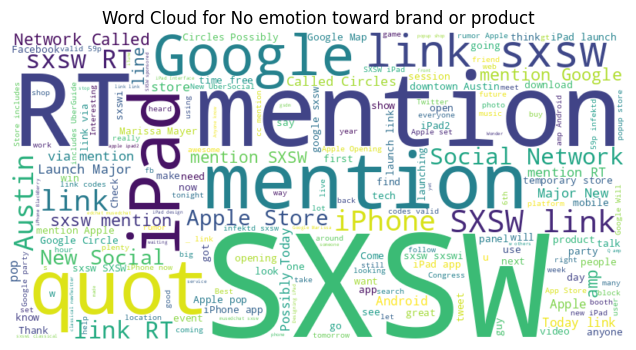

In [14]:
from wordcloud import WordCloud

# Generate word clouds for each emotion
emotions = train_df['is_there_an_emotion_directed_at_a_brand_or_product'].unique()

for emotion in emotions:
    text = ' '.join(train_df[train_df['is_there_an_emotion_directed_at_a_brand_or_product'] == emotion]['tweet_text'].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {emotion}')
    plt.axis('off')
    plt.show()


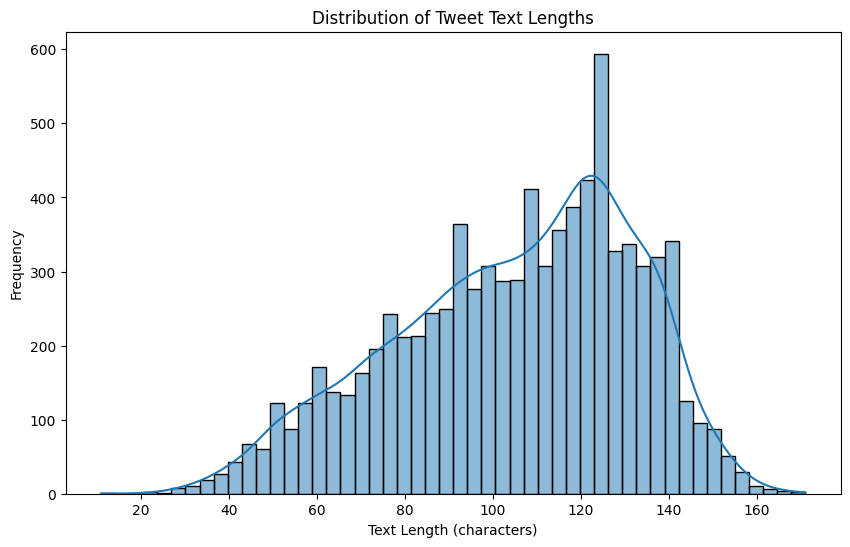

In [15]:
# Calculate text lengths
train_df['text_length'] = train_df['tweet_text'].apply(len)

# Plot distribution of text lengths
plt.figure(figsize=(10,6))
sns.histplot(data=train_df, x='text_length', bins=50, kde=True)
plt.title('Distribution of Tweet Text Lengths')
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.show()


> **This is Essential for setting the tokenizer max length later**

### Balancing the dataset

Handling Class Imbalance:

- If certain emotion classes are underrepresented, consider collecting more data for those classes.

> Apply resampling techniques like SMOTE or class weighting during model training.

> we can use 'compute_class_weight' from sklearn.utils.class_weight to calulate the weights and pass it to crossentropy loss for product and emotion that can make a stable trainig. Assign higher weights to minority classes during model training to penalize misclassifications more heavily.


Data Quality Enhancement:
>
> Cleaning Text Data: Remove noise such as URLs, special characters.

Ensure Diverse Representation:

> Verify that all products or apps have a sufficient number of associated emotion labels to prevent the model from being biased towards specific products.

Data Augmentation:

- Implementing data augmentation can help generate more diverse training samples.

>Synonym Replacement

>Back Translation

>Random Insertion and Deletion

> Using paraphrase model to create more sample.

> Syntehic data generation using any LLM

For Simiplicity here we are not going with any agumnetation , but you can use nlpaug or other Open source lib.


In [16]:
train_df['emotion_in_tweet_is_directed_at'] = train_df['emotion_in_tweet_is_directed_at'].fillna("No Product")

In [17]:
train_df.isna().sum()

tweet_text                                            0
emotion_in_tweet_is_directed_at                       0
is_there_an_emotion_directed_at_a_brand_or_product    0
text_length                                           0
dtype: int64

In [18]:
no_emotion_df = train_df[train_df['is_there_an_emotion_directed_at_a_brand_or_product'] == "No emotion toward brand or product"]
positive_emotion_df = train_df[train_df['is_there_an_emotion_directed_at_a_brand_or_product'] == "Positive emotion"]
negative_emotion_df = train_df[train_df['is_there_an_emotion_directed_at_a_brand_or_product'] == "Negative emotion"]

In [19]:
no_emotion_df.shape , positive_emotion_df.shape, negative_emotion_df.shape

((5388, 4), (2672, 4), (519, 4))

In [20]:
# Downsample 'No emotion toward brand or product' to match the smallest class size (519)
balanced_no_emotion_df = no_emotion_df.sample(n=len(negative_emotion_df), random_state=42)

In [21]:
balanced_df = pd.concat([balanced_no_emotion_df, positive_emotion_df, negative_emotion_df])

In [22]:
balanced_df.is_there_an_emotion_directed_at_a_brand_or_product.value_counts() , balanced_df.shape

(is_there_an_emotion_directed_at_a_brand_or_product
 Positive emotion                      2672
 No emotion toward brand or product     519
 Negative emotion                       519
 Name: count, dtype: int64,
 (3710, 4))

In [23]:
emotion_encoder = LabelEncoder()
product_encoder = LabelEncoder()

balanced_df['emotion_label'] = emotion_encoder.fit_transform(balanced_df['is_there_an_emotion_directed_at_a_brand_or_product'])
balanced_df['product_label'] = product_encoder.fit_transform(balanced_df['emotion_in_tweet_is_directed_at'])

In [24]:
emotion_mapping = dict(zip(emotion_encoder.classes_, range(len(emotion_encoder.classes_))))
print("Emotion Mapping:")
print(emotion_mapping)

# Get the mapping for product targets
product_mapping = dict(zip(product_encoder.classes_, range(len(product_encoder.classes_))))
print("\nProduct Mapping:")
print(product_mapping)

Emotion Mapping:
{'Negative emotion': 0, 'No emotion toward brand or product': 1, 'Positive emotion': 2}

Product Mapping:
{'Android': 0, 'Android App': 1, 'Apple': 2, 'Google': 3, 'No Product': 4, 'Other Apple product or service': 5, 'Other Google product or service': 6, 'iPad': 7, 'iPad or iPhone App': 8, 'iPhone': 9}


In [25]:
emotion_encoder.classes_ , product_encoder.classes_

(array(['Negative emotion', 'No emotion toward brand or product',
        'Positive emotion'], dtype=object),
 array(['Android', 'Android App', 'Apple', 'Google', 'No Product',
        'Other Apple product or service',
        'Other Google product or service', 'iPad', 'iPad or iPhone App',
        'iPhone'], dtype=object))

In [26]:
# balanced_df.product_label.value_counts()
# balanced_df.emotion_label.value_counts()
balanced_df[400:700]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,text_length,emotion_label,product_label
6365,RT @mention The countdown to #SXSW has begun! @mention will be there��_ Pick up &quot;Fried Speakers&quot; on iTunes {link},No Product,No emotion toward brand or product,123,1,4
6738,"Not a rumor any longer, Apple to open up a pop up store on Congress for the iPad2 launch during #SXSW. {link} #GeeksRejoice",No Product,No emotion toward brand or product,123,1,4
4520,"Nope, @mention Is NOT Launching Its Own Social Network at #SXSW {link}",No Product,No emotion toward brand or product,70,1,4
5115,RT @mention Apple built an experience ecosystem with the iPod. The MP3 player is just an app. #critthink #sxsw,No Product,No emotion toward brand or product,111,1,4
1355,"In Austin: not surprising, most popular accessory seems to be the ipad. closely followed up by BBQ pork waffle cone. #sxsw",No Product,No emotion toward brand or product,122,1,4
...,...,...,...,...,...,...
462,"Before It Even Begins, Apple Wins��SXSW {link} via @mention #apple #sxsw",Apple,Positive emotion,72,2,2
463,"Before It Even Begins, Apple Wins SXSW: {link} Via @mention @mention #Apple #SXSW",Apple,Positive emotion,81,2,2
464,Badgeless event! Free Drinks! ���@mention Heading to free Google-sponsored happy hour for Semantic Web Austin @mention Fogo de Ch��o #sxsw�۝,Google,Positive emotion,140,2,3
465,"BEST SWAG EVER. Thanks @mention My charging iPhone thanks you, too. #SXSW {link}",iPhone,Positive emotion,80,2,9


In [ ]:
# balanced_df.to_csv("train_val_01.csv", index=False)

## 3. Data Preparation

In [28]:
balanced_df = pd.read_csv("train_val_01.csv")
df = balanced_df.iloc[:, :-2]

In [29]:
train_df = df.rename(columns={
    'emotion_in_tweet_is_directed_at': 'product_label',
    'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion_label'
})

test_df = test_df.rename(columns={
    'Tweet': 'tweet_text',
})

### Cleaning Text Data

In [30]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)     # Remove mentions
    text = re.sub(r'#\w+', '', text)     # Remove hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters and numbers
    text = text.lower()                   # Convert to lowercase
    # text = ' '.join(word for word in text.split() if word not in stop)  # Remove stopwords
    return text

train_df['cleaned_text'] = train_df['tweet_text'].apply(clean_text)
test_df['cleaned_text'] = test_df['tweet_text'].apply(clean_text)

### Label Encoding

In [31]:
product_encoder = LabelEncoder()
emotion_encoder = LabelEncoder()

train_df['product'] = product_encoder.fit_transform(train_df['product_label'])
train_df['emotion'] = emotion_encoder.fit_transform(train_df['emotion_label'])

product_label_mapping = dict(zip(product_encoder.classes_, 
                                [int(x) for x in product_encoder.transform(product_encoder.classes_)]))
emotion_label_mapping = dict(zip(emotion_encoder.classes_, 
                                [int(x) for x in emotion_encoder.transform(emotion_encoder.classes_)]))

In [32]:
print("Product Label Mapping:", product_label_mapping)
print("Emotion Label Mapping:", emotion_label_mapping)

Product Label Mapping: {'Android': 0, 'Android App': 1, 'Apple': 2, 'Google': 3, 'No Product': 4, 'Other Apple product or service': 5, 'Other Google product or service': 6, 'iPad': 7, 'iPad or iPhone App': 8, 'iPhone': 9}
Emotion Label Mapping: {'Negative emotion': 0, 'No emotion toward brand or product': 1, 'Positive emotion': 2}


In [33]:
train_df, val_df= train_test_split( train_df, test_size=0.1, stratify=train_df['emotion_label'], random_state=42)

In [34]:
train_df.head(2)

,tweet_text,product_label,emotion_label,cleaned_text,product,emotion
737,How could I forget my cell phone today for #SXSW what a fail glad I have my iPad #lifelinetotheworld,iPad,Positive emotion,how could i forget my cell phone today for what a fail glad i have my ipad,7,2
436,RT @mention Confusion over Google Circles. Google claim Circles is not being released at #sxsw and is not even in development. {link},No Product,No emotion toward brand or product,rt confusion over google circles google claim circles is not being released at and is not even in development link,4,1


In [35]:
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Train size: 3339
Validation size: 371
Test size: 504


### Converting to Dataset

In [41]:
# Convert pandas DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Create a DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    # 'test': test_dataset,
})

In [42]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

def preprocess_function(examples):
    return tokenizer(
        examples['cleaned_text'], truncation=True, padding='max_length', max_length=170
    )
tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map: 100%|██████████████████████████| 371/371 [00:00<00:00, 15592.21 examples/s]


In [43]:
def combine_labels(example):
    example['labels'] = [example['product'], example['emotion']]
    return example

tokenized_dataset = tokenized_dataset.map(combine_labels)


Map: 100%|██████████████████████████| 371/371 [00:00<00:00, 12918.30 examples/s]


In [44]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['tweet_text', 'product_label', 'emotion_label', 'cleaned_text', 'product', 'emotion', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 3339
    })
    validation: Dataset({
        features: ['tweet_text', 'product_label', 'emotion_label', 'cleaned_text', 'product', 'emotion', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 371
    })
})

In [45]:
data_collator = DataCollatorWithPadding(tokenizer)

## 4. Multitask Model Architecture
* Create a custom model that has two classification heads on top of BERT.
* You can choose other similar encoder model like FacebookAI/roberta-base, microsoft/deberta-v3-base etc as well.

>Multitask Learning: This model performs multitask learning by sharing BERT’s representations between two tasks, which helps the model generalize better and leverage any shared patterns between emotion and product recognition.

>Separate Task Heads: Each task has its own classifier layer, enabling independent classification of product and emotion categories.

>Shared BERT Backbone: The BERT backbone is shared between both tasks, which helps reduce the model size compared to training two separate models.

>Combined Loss for Training: During training, the combined loss from both tasks is minimized, which encourages the model to perform well on both tasks.

This approach is efficient and often improves performance, especially if there is some correlation or shared information between the tasks (e.g., a product might be associated with a typical emotion). The MultitaskModel is therefore a useful architecture when dealing with related classification tasks on the same data

In [46]:
class MultitaskModel(nn.Module):
    def __init__(self, model_name, num_product_labels, num_emotion_labels):
        super(MultitaskModel, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        hidden_size = self.bert.config.hidden_size
        self.dropout = nn.Dropout(self.bert.config.hidden_dropout_prob)
        
        self.product_classifier = nn.Linear(hidden_size, num_product_labels)
        self.emotion_classifier = nn.Linear(hidden_size, num_emotion_labels)
    
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        labels=None,  # labels is a tensor of shape (batch_size, 2)
    ):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output  # [CLS] token representation
        pooled_output = self.dropout(pooled_output)
        
        product_logits = self.product_classifier(pooled_output)
        emotion_logits = self.emotion_classifier(pooled_output)
        
        loss = None
        if labels is not None:
            product_labels = labels[:, 0]
            emotion_labels = labels[:, 1]
            loss_fct = nn.CrossEntropyLoss()
            product_loss = loss_fct(product_logits, product_labels)
            emotion_loss = loss_fct(emotion_logits, emotion_labels)
            loss = product_loss + emotion_loss  # Combine losses
        
        return {
            'loss': loss,
            'logits': (product_logits, emotion_logits)
        }

In [47]:
num_product_labels = train_df['product'].nunique()
num_emotion_labels = train_df['emotion'].nunique()

print(f"Number of product labels: {num_product_labels}")
print(f"Number of emotion labels: {num_emotion_labels}")

Number of product labels: 10
Number of emotion labels: 3


In [48]:
model = MultitaskModel(
    model_name='bert-base-uncased',
    num_product_labels=num_product_labels,
    num_emotion_labels=num_emotion_labels,
)

In [49]:
model.to(device)
print("Model device:", next(model.parameters()).device)

Model device: cuda:0


In [50]:
# model
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['tweet_text', 'product_label', 'emotion_label', 'cleaned_text', 'product', 'emotion', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 3339
    })
    validation: Dataset({
        features: ['tweet_text', 'product_label', 'emotion_label', 'cleaned_text', 'product', 'emotion', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 371
    })
})

In [51]:
tokenized_dataset = tokenized_dataset.remove_columns(['tweet_text', '__index_level_0__','cleaned_text','product_label', 'emotion_label'])
tokenized_dataset.set_format(type='torch')

In [52]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['product', 'emotion', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 3339
    })
    validation: Dataset({
        features: ['product', 'emotion', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 371
    })
})

In [53]:
training_args = TrainingArguments(
    output_dir='saved_model',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=20,
)

/home/d3v/anaconda3/envs/wysa/lib/python3.9/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### Define Computer Metrics

The compute_metrics function is designed to evaluate the performance of the MultitaskModel on both the product and sentiment (emotion) classification tasks. It calculates accuracy for each task based on the model’s predictions and true labels.

In [54]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    product_logits, sentiment_logits = logits
    product_preds = np.argmax(product_logits, axis=1)
    sentiment_preds = np.argmax(sentiment_logits, axis=1)

    product_labels = labels[:, 0]
    sentiment_labels = labels[:, 1]

    product_accuracy = accuracy_score(product_labels, product_preds)
    sentiment_accuracy = accuracy_score(sentiment_labels, sentiment_preds)

    return {
        'product_accuracy': product_accuracy,
        'sentiment_accuracy': sentiment_accuracy,
    }

## 5. Training

In [55]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()


/tmp/ipykernel_4894/96298505.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Product Accuracy,Sentiment Accuracy
1,1.782700,1.691556,0.690027,0.735849
2,1.147800,1.511051,0.722372,0.760108
3,0.985300,1.471427,0.719677,0.778976


TrainOutput(global_step=1254, training_loss=1.5624175132556775, metrics={'train_runtime': 672.4929, 'train_samples_per_second': 14.895, 'train_steps_per_second': 1.865, 'total_flos': 0.0, 'train_loss': 1.5624175132556775, 'epoch': 3.0})

In [ ]:
# trainer.save_model("MODEL-2")

In [56]:
torch.save(model.state_dict(), 'MODEL_04/pytorch_model.bin')
tokenizer.save_pretrained('MODEL_04/')

('MODEL_04/tokenizer_config.json',
 'MODEL_04/special_tokens_map.json',
 'MODEL_04/vocab.txt',
 'MODEL_04/added_tokens.json',
 'MODEL_04/tokenizer.json')

In [ ]:
# model.save_pretrained('MODEL_01/')

## 6. Inference

In [57]:
# Load and Process the Test data

# tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
test_set = DatasetDict({
    'test': test_dataset,
})

def preprocess_function(examples):
    return tokenizer(
        examples['cleaned_text'], truncation=True, padding='max_length', max_length=128
    )
tokenized_test_set = test_set.map(preprocess_function, batched=True)

Map: 100%|██████████████████████████| 504/504 [00:00<00:00, 12906.10 examples/s]


In [58]:
tokenized_test_set

DatasetDict({
    test: Dataset({
        features: ['tweet_text', 'cleaned_text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 504
    })
})

In [59]:
tokenized_test_set
tokenized_test_set = tokenized_test_set.remove_columns(['tweet_text'])
tokenized_test_set.set_format(type='torch')

In [60]:
state_dict = torch.load('MODEL_04/pytorch_model.bin', map_location=torch.device('cuda'))
model.load_state_dict(state_dict)

# Set the model to evaluation mode
model.eval()

/tmp/ipykernel_4894/4148028148.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('MODEL_04/pytorch_model.bin', map_location=torch.device('cuda'))


MultitaskModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [ ]:
test_dataset

In [ ]:
tokenized_dataset["validation"]

### Testing On Validation set

Evaluating the model's performance is crucial to understand its effectiveness and areas of improvement.

Evaluation Metrics
>We'll use the following metrics to assess the model's performance:

>Accuracy: The proportion of correctly predicted instances.

>Precision, Recall, F1-Score: To evaluate the model's performance on each class, especially important in the presence of class imbalance.

>Confusion Matrix: To visualize the model's performance across different classes.

In [61]:
# Set device to match model's device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.eval()
predictions = []
true_emotions = []
true_products = []

for batch in tokenized_dataset["validation"]:
    # Move inputs to the same device as the model
    inputs = {
        'input_ids': batch['input_ids'].unsqueeze(0).to(device),
        'attention_mask': batch['attention_mask'].unsqueeze(0).to(device)
    }
    
    with torch.no_grad():
        outputs = model(**inputs)

        # Assuming the model output contains logits for both product and emotion in a tuple or single tensor
        if isinstance(outputs['logits'], tuple):
            product_logits = outputs['logits'][0]
            emotion_logits = outputs['logits'][1]
        else:
            # Adjust this based on the number of classes for emotion and product
            product_logits = outputs['logits'][:, len(product_encoder.classes_):]
            emotion_logits = outputs['logits'][:, :len(emotion_encoder.classes_)]
            

        # Predicting the emotion and product labels
        emotion_pred = torch.argmax(emotion_logits, dim=1).item()
        product_pred = torch.argmax(product_logits, dim=1).item()
        
    predictions.append((emotion_pred, product_pred))
    
    # Append true labels from the batch
    true_emotions.append(batch['emotion'])
    true_products.append(batch['product'])

# Separate predictions
pred_emotions, pred_products = zip(*predictions)

# Classification Report for Emotions
print("Emotion Classification Report:")
print(classification_report(true_emotions, pred_emotions, target_names=emotion_encoder.classes_))

# Classification Report for Products
print("Product Classification Report:")
print(classification_report(true_products, pred_products, target_names=product_encoder.classes_))


Emotion Classification Report:
                                    precision    recall  f1-score   support

                  Negative emotion       0.65      0.58      0.61        52
No emotion toward brand or product       0.50      0.15      0.24        52
                  Positive emotion       0.81      0.94      0.87       267

                          accuracy                           0.78       371
                         macro avg       0.65      0.56      0.57       371
                      weighted avg       0.75      0.78      0.75       371

Product Classification Report:
                                 precision    recall  f1-score   support

                        Android       0.60      0.43      0.50         7
                    Android App       0.71      0.83      0.77         6
                          Apple       0.83      0.82      0.82        66
                         Google       0.65      0.73      0.69        41
                     No Product      

/home/d3v/anaconda3/envs/wysa/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/d3v/anaconda3/envs/wysa/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/d3v/anaconda3/envs/wysa/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

### 7. Generate Prediction for Test Set

In [62]:
# Initialize lists to store predictions
test_emotion_predictions = []
test_product_predictions = []

for batch in tokenized_test_set["test"]:
    # Prepare inputs and move them to the model's device
    inputs = {
        'input_ids': batch['input_ids'].unsqueeze(0).to(device),
        'attention_mask': batch['attention_mask'].unsqueeze(0).to(device)
    }
    
    # Perform inference without gradient computation
    with torch.no_grad():
        outputs = model(**inputs)

        # Check if the model returns a tuple of logits for each task
        if isinstance(outputs['logits'], tuple):
            product_logits = outputs['logits'][0]
            emotion_logits = outputs['logits'][1]
        else:
            # If it's a single tensor, slice it based on the number of classes
            product_logits = outputs['logits'][:, len(product_encoder.classes_):]
            emotion_logits = outputs['logits'][:, :len(emotion_encoder.classes_)]
        
        emotion_pred_index = torch.argmax(emotion_logits, dim=1).item()
        product_pred_index = torch.argmax(product_logits, dim=1).item()

        emotion_pred_class = emotion_encoder.inverse_transform([emotion_pred_index])[0]
        product_pred_class = product_encoder.inverse_transform([product_pred_index])[0]

    test_emotion_predictions.append(emotion_pred_class)
    test_product_predictions.append(product_pred_class)

import pandas as pd

test_predictions_df = pd.DataFrame({
    "emotion_prediction": test_emotion_predictions,
    "product_prediction": test_product_predictions
})


In [71]:
test_predictions_df["tweet"] = test_df["cleaned_text"]

In [72]:
test_predictions_df.head()

,emotion_prediction,product_prediction,tweet
0,Positive emotion,iPad or iPhone App,handheld hobo drafthouse launches hobo with a shotgun iphone app link
1,Negative emotion,Apple,again rt line at the apple store is insane
2,Positive emotion,iPhone,boooo rt flipboard is developing an iphone version not android says
3,Positive emotion,iPad or iPhone App,thanks to for publishing the news of new medical apps at the conf blog link
4,Positive emotion,iPad,quotapple has opened a popup store in austin so the nerds in town for can get their new ipads link


In [75]:
test_predictions_df.shape , test_predictions_df.to_csv("test_prediction.csv")

((504, 3), None)

In [76]:
import joblib
# Save the encoders to files
joblib.dump(product_encoder, 'product_encoder.joblib')
joblib.dump(emotion_encoder, 'emotion_encoder.joblib')

['emotion_encoder.joblib']